In [29]:
import anndata
import networkx as nx
import scanpy as sc
from anndata import AnnData
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.config import configure_dataset
import dill

In [30]:
dataset = "pbmc"
result_path = f"./dataset/{dataset}/result"

rna = anndata.read_h5ad(f"./dataset/{dataset}/rna_hvg.h5ad")
atac = anndata.read_h5ad(f"./dataset/{dataset}/atac_hvg.h5ad")
graph = nx.read_graphml(f"./dataset/{dataset}/guidance-hvf.graphml.gz")

rna.obs['cell type'] = rna.obs['cell_type']
atac.obs['cell type'] = atac.obs['cell_type']

rna.X=rna.layers['counts']
atac.X=atac.layers['counts']

adatas=[rna, atac]
modal_names=["RNA", "ATAC"]
prob=['NB','NB']
rep = ['X_init', 'X_init']

print(rna)
print(atac)

vertices = sorted(graph.nodes)
for idx, adata in enumerate(adatas):
    configure_dataset(adata, prob[idx], 
                      use_highly_variable=True,
                      use_rep=rep[idx])

data = dict(zip(modal_names, adatas))

with open(f'{result_path}/ckpt/monae.dill', 'rb') as f:
    covel = dill.load(f)

print("Integration data")
for modal_name in modal_names:
    data[modal_name].obsm['embedding'] = covel.encode_data(modal_name, data[modal_name])
    
combined = anndata.AnnData(
        obs=pd.concat([adata.obs for adata in adatas], join="inner"),
        obsm={"embedding": np.concatenate([adata.obsm["embedding"] for adata in adatas]),
              "X_umap_ori": np.concatenate([adata.obsm["X_umap"] for adata in adatas])}
)

combined.obs["domain"] = pd.Categorical(
        combined.obs["domain"],
)

feature_embeddings = covel.encode_graph(graph)
feature_embeddings = pd.DataFrame(feature_embeddings, index=covel.vertices)

for adata in adatas:
    adata.varm["embedding"] = feature_embeddings.reindex(adata.var_names).to_numpy()

print("UMAP vis integration data, in combined.h5ad X_umap")
sc.pp.neighbors(combined, 
                use_rep="embedding", metric="cosine")
sc.tl.umap(combined)

AnnData object with n_obs × n_vars = 9631 × 2000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'pbg_id', 'cell type'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'pbg_id'
    uns: 'cell_type_colors', 'disc', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_init', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'disc', 'raw'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 9631 × 16386
    obs: 'domain', 'protocol', 'dataset', 'orig

/home/tangzhenchao/anaconda3/envs/monae/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


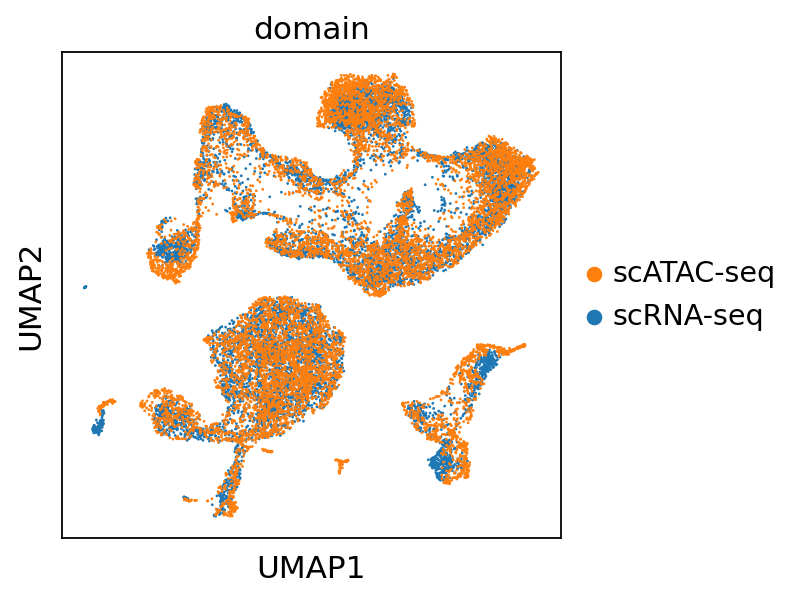

/home/tangzhenchao/anaconda3/envs/monae/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


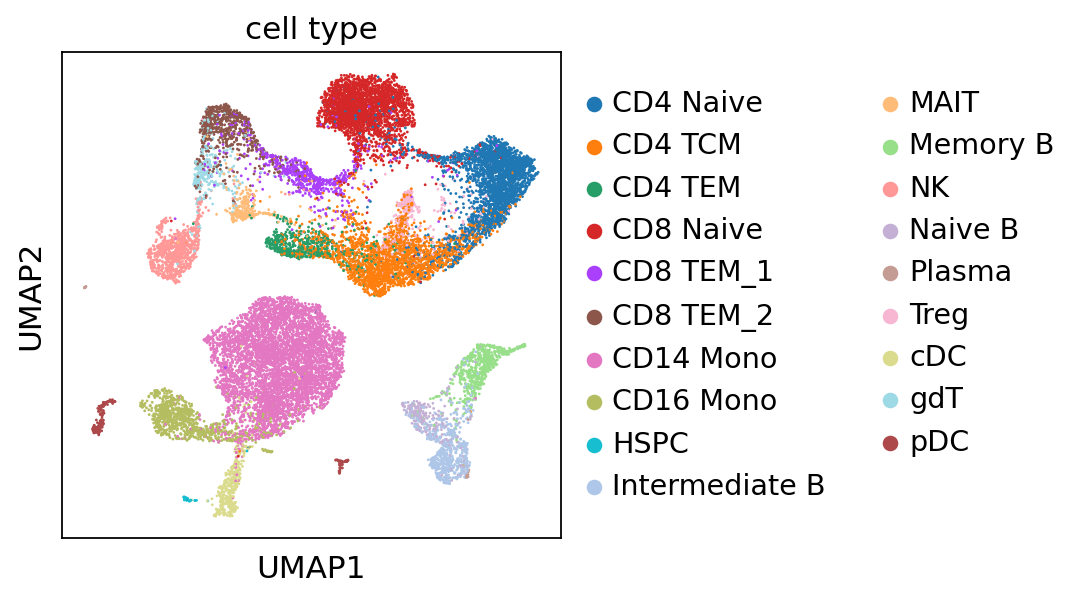

In [31]:
sc.set_figure_params(dpi=80)

combined.uns["domain_colors"] = list(sns.color_palette(n_colors=len(modal_names)).as_hex())[::-1]

sc.pl.umap(combined, color=['domain'])
sc.pl.umap(combined, color=['cell type'])